In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback

sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    google.colab.drive.mount('/content/gdrive')
    OUTPUT_DIR = "/content/gdrive/My Drive/output"
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        !git clone https://github.com/FriedChips/dl_basics.git
        sys.path.insert(0,'../working/dl_basics')    
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

2023-04-14 19:46:41.010348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running locally on beta.


In [2]:
from data_gen.modulo_arithmetic import addition_modulo_data
#import models
import utils

In [3]:
P = {}

P["addition_modulo_data"] = {
    "p_max" : 113,
    "train_size" : 0.3,
    "add_equal_sign" : False,
    "seed" : 42,
}

x_train, x_val, y_train, y_val = addition_modulo_data(**P["addition_modulo_data"])
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)
print(x_train.dtype, x_val.dtype, y_train.dtype, y_val.dtype)
print(x_train[0], y_train[0])

(3830, 2) (8939, 2) (3830,) (8939,)
int32 int32 int32 int32
[24 37] 61


In [4]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, Dense, Conv2D, Flatten


def build_model(
        seq_len,
        vocab_size,
        embed_dim,
        mlp_dim,
):

    inp = Input(shape=(seq_len,), dtype=np.int32)
    x = Embedding(vocab_size, embed_dim, input_length=seq_len)(inp)
    x = tf.expand_dims(x, -1)
    x = Conv2D(mlp_dim, kernel_size=(seq_len, embed_dim), use_bias=False)(x)
    x = tf.nn.gelu(x)
    x = Flatten()(x)
    x = Dense(vocab_size, use_bias=False)(x)
    out = x
    
    model = Model(inp, out, name="mlp_grokking")
    return model

In [5]:
# init new run

'''
P["model_name"] = "gru_01"
P["model_build_params"] = {
    "gru_units" : 128,
    "num_outputs" : P["addition_modulo_data"]["p_max"],
    "input_shape" : (2,),
    "num_hidden_gru" : 0,
    "use_embedding" : True,
    "vocab_size" : P["addition_modulo_data"]["p_max"],
    "embedding_dim" : 128,
    "return_final_hidden" : True,
}

P["model_name"] = "transformer_01"
P["model_build_params"] = {
    "input_shape" : (3,),
    "num_heads" : 4,
    "num_tokens" : P["addition_modulo_data"]["p_max"] + 1, # + 1 for the "=" sign
    "embedding_dim" : 128,
    "return_final_token_only" : True,
}

model = eval("models." + P["model_name"])(**P["model_build_params"])
'''

P["model_build_params"] = {
    "seq_len" : 2,
    "vocab_size" : P["addition_modulo_data"]["p_max"],
    "embed_dim" : 128,
    "mlp_dim" : 128,
}

model = build_model(**P["model_build_params"])

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-3, weight_decay=1),
    metrics = [ "accuracy" ]
)

model.summary()

P["run_dir"] = model.name + datetime.datetime.now().strftime('-%y%m%d-%H%M%S')
print("Run dir :", P["run_dir"])

run = utils.TrainingRun()
weight_norm_logger = utils.LogWeightNorms()

Model: "mlp_grokking"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 embedding (Embedding)       (None, 2, 128)            14464     
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 2, 128, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 128)         32768     
                                                                 
 tf.nn.gelu (TFOpLambda)     (None, 1, 1, 128)         0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 113)              

2023-04-14 19:46:43.867906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 19:46:43.869848: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Run dir : mlp_grokking-230414-194644


In [6]:
NUM_EPOCHS = 1024 // 128
#lr_sched = utils.Schedule_ExpCos_Segments([[-3,-3, NUM_EPOCHS]])

history = model.fit(
    x_train, y_train,
    epochs = NUM_EPOCHS,
    batch_size = len(x_train),
    validation_data = (x_val, y_val),
    callbacks=[
        TqdmCallback(verbose=0),
        weight_norm_logger,
    ],        
    verbose=0)

run.update_history(history)

0epoch [00:00, ?epoch/s]

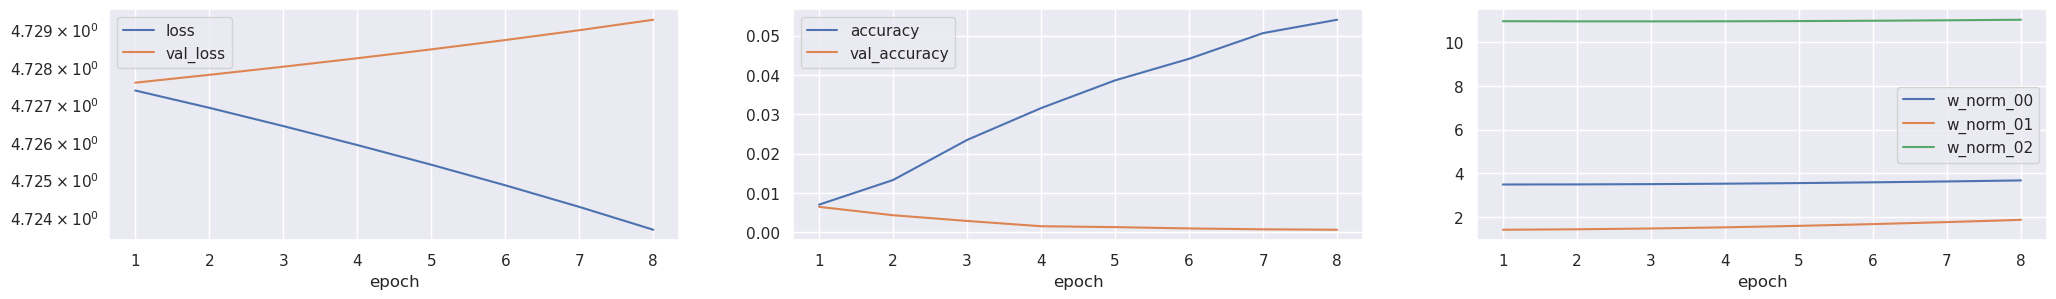

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(25,3))

sns.lineplot(data=run.history[["loss", "val_loss"]], ax=axs[0], dashes=False);
axs[0].set_yscale("log");

sns.lineplot(data=run.history[["accuracy", "val_accuracy"]], ax=axs[1], dashes=False);

sns.lineplot(data=weight_norm_logger.norms_dataframe(), ax=axs[2], dashes=False);

In [8]:
log_dir = os.path.join(OUTPUT_DIR, P["run_dir"])
run.save_state(log_dir, P, model)
weight_norm_logger.norms_to_csv(log_dir)

In [ ]:
#P, model = run.load_state("../output/gru_01-230407-220913")